# GLM: LINEAR REGRESSION

## Load libraries

In [17]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import bambi as bmb

from pymc import HalfCauchy, Model, Normal, sample

print("Bambi:", bmb.__version__)
print("PyMC:", pm.__version__)

Running on PyMC v5.7.1


In [3]:
seed = 8927

rng = np.random.default_rng(seed)

In [5]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

## Generating data

In [6]:
size = 200
true_intercept = 1
true_slope = 2

In [7]:
x = np.linspace(0, 1, size)

In [8]:
trueRegLine = true_intercept + true_slope * x

In [9]:
y = trueRegLine + rng.normal(scale = 0.5, size = size)

In [10]:
data = pd.DataFrame(dict(x = x, y = y))
data.head()

,x,y
0,0.000000,0.888679
1,0.005025,1.672880
2,0.010050,0.734615
3,0.015075,1.364275
4,0.020101,1.612892


## Plot the data

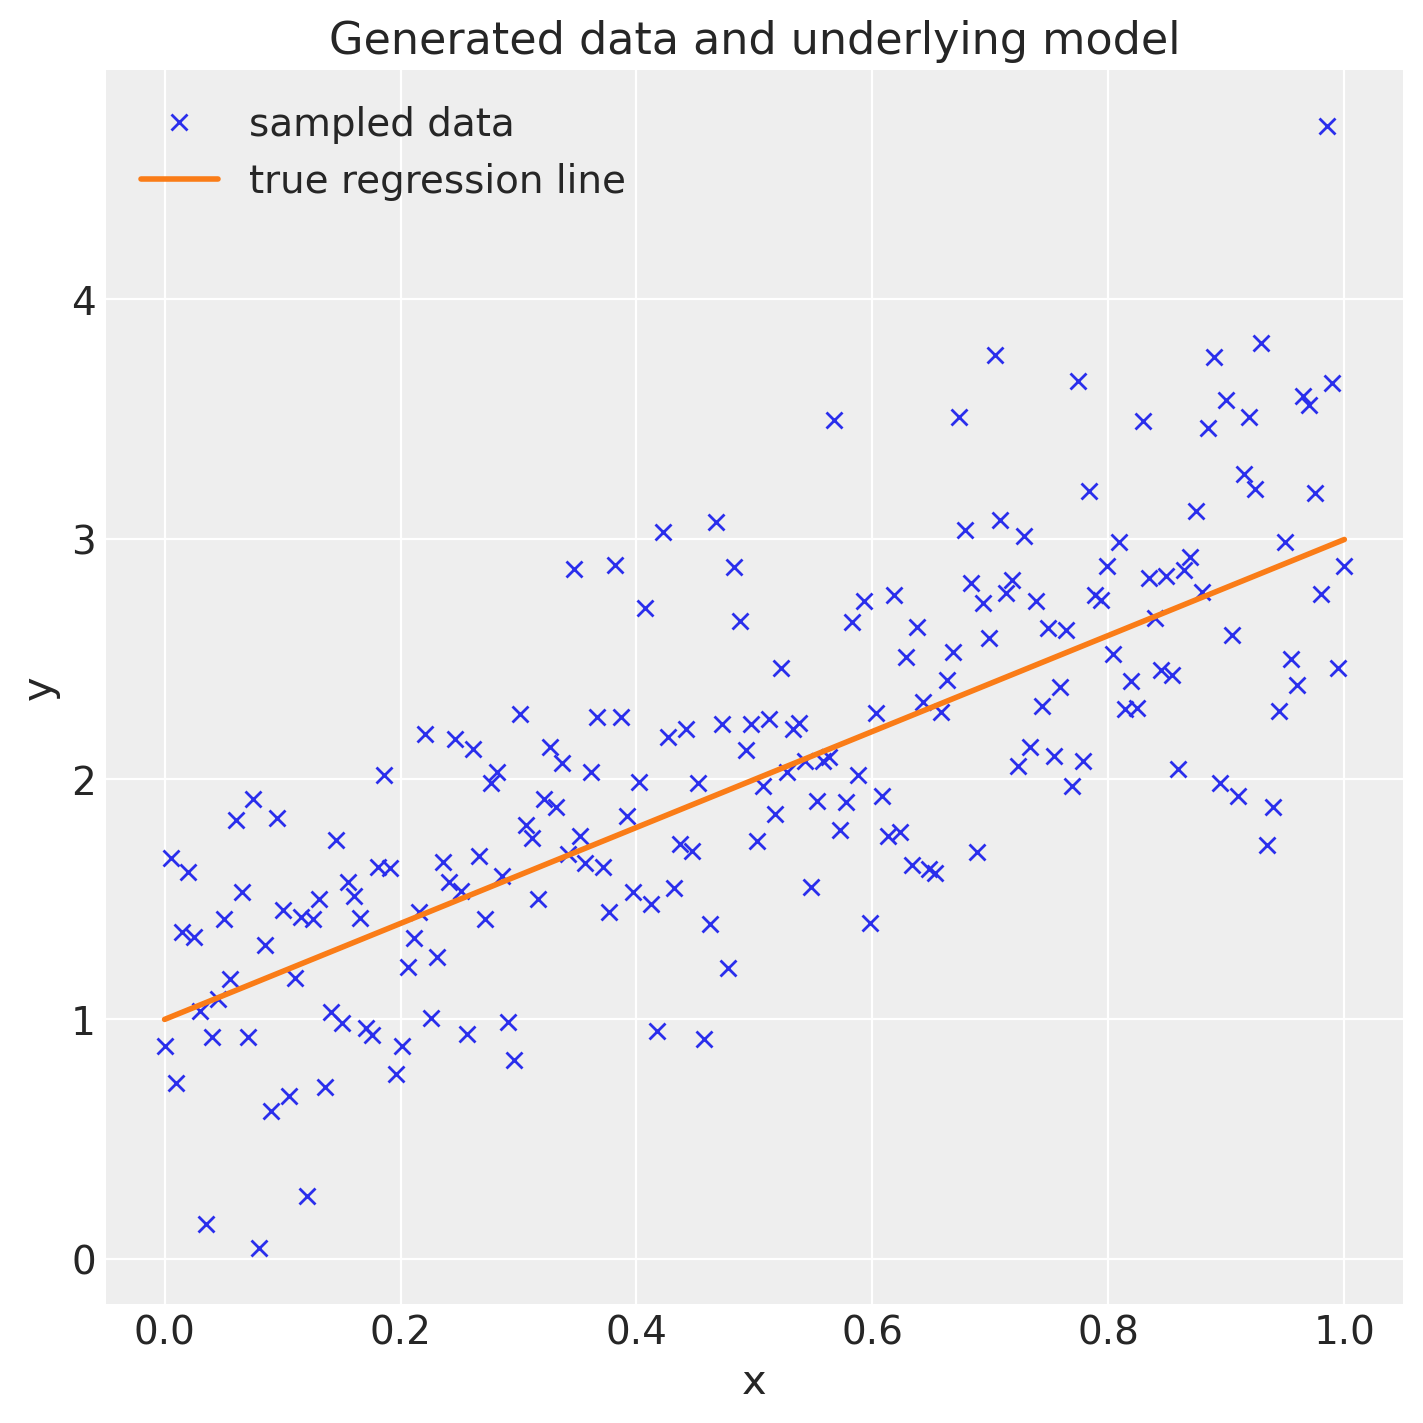

In [12]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, trueRegLine, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Model specification

In [28]:
with Model() as model:
    # Define priors
    sigma = HalfCauchy('sigma', beta = 10)
    intercept = Normal('intercept', 0, sigma = 20)
    slope = Normal('slope', 0, sigma = 20)
    
    # Define likelyhood
    likelihood = Normal('y', mu = intercept + slope * x, sigma = sigma, observed = y)

## Run Chains

In [29]:
with model:
    idata = sample(3000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, intercept, slope]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 68 seconds.


## Model specification using bambi

In [50]:
model = bmb.Model('y ~ 1 + x', data)
model

       Formula: y ~ 1 + x
        Family: gaussian
          Link: mu = identity
  Observations: 200
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2.0759, sigma: 3.9401)
            x ~ Normal(mu: 0.0, sigma: 6.8159)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.791)

In [53]:
idata = model.fit(draws = 3000, chains = 4, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [y_sigma, Intercept, x]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


## Analysing the model

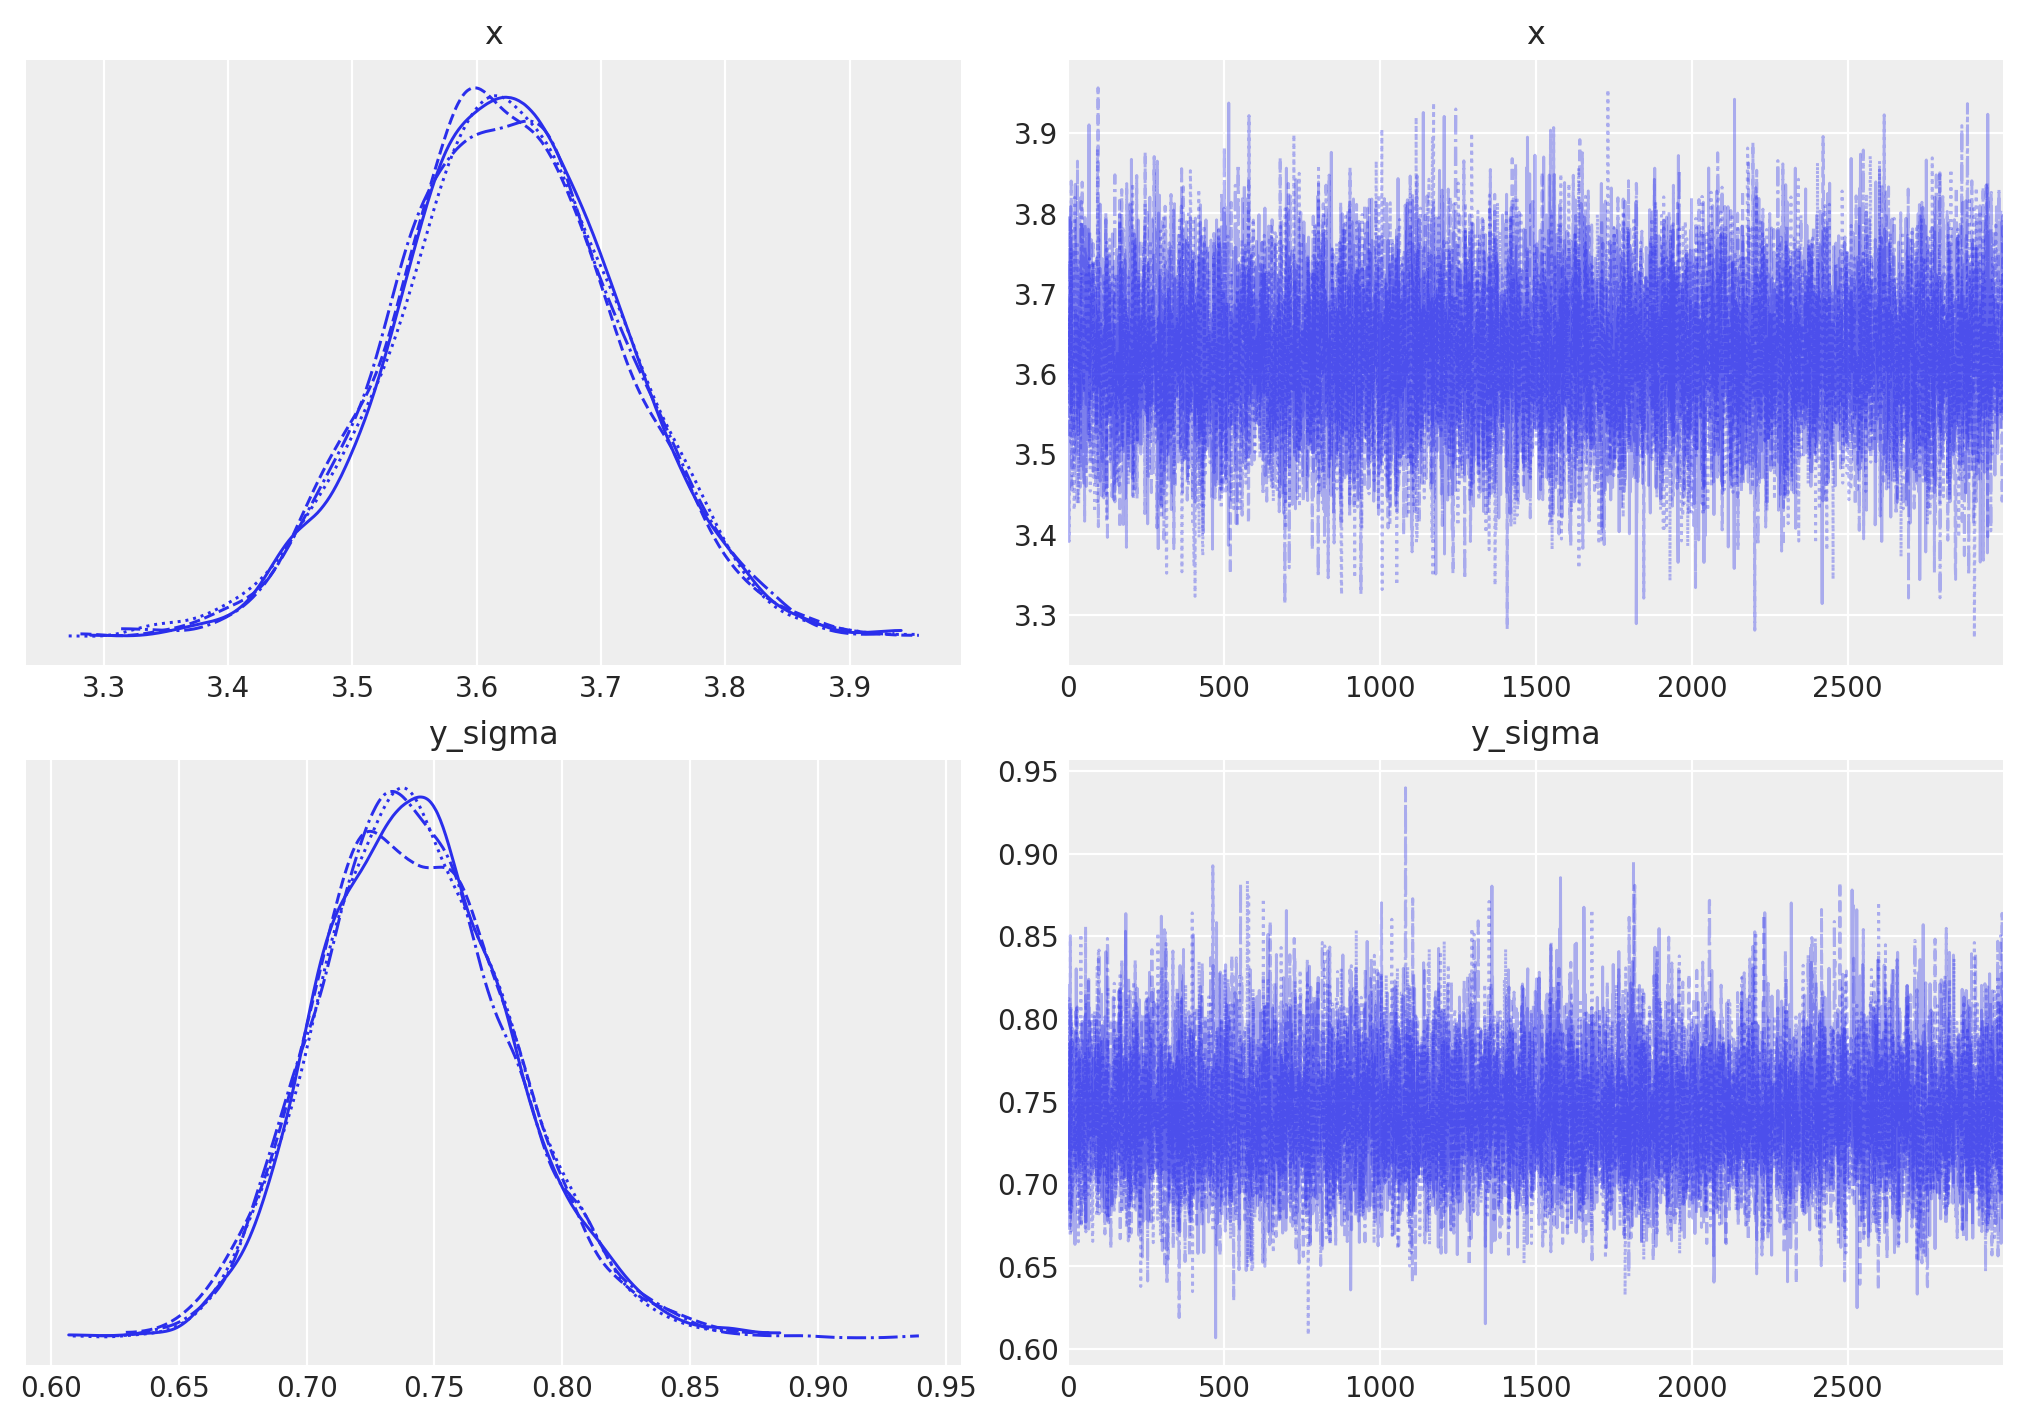

In [46]:
az.plot_trace(idata, figsize = (10, 7));

In [54]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [55]:
idata.posterior['y_model'] = idata.posterior['Intercept'] + idata.posterior['x'] * xr.DataArray(x)

In [56]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

C:\Users\bacos1\.conda\envs\pymc_env\Lib\site-packages\arviz\plots\lmplot.py:211: UserWarning: posterior_predictive not found in idata
  warnings.warn("posterior_predictive not found in idata", UserWarning)


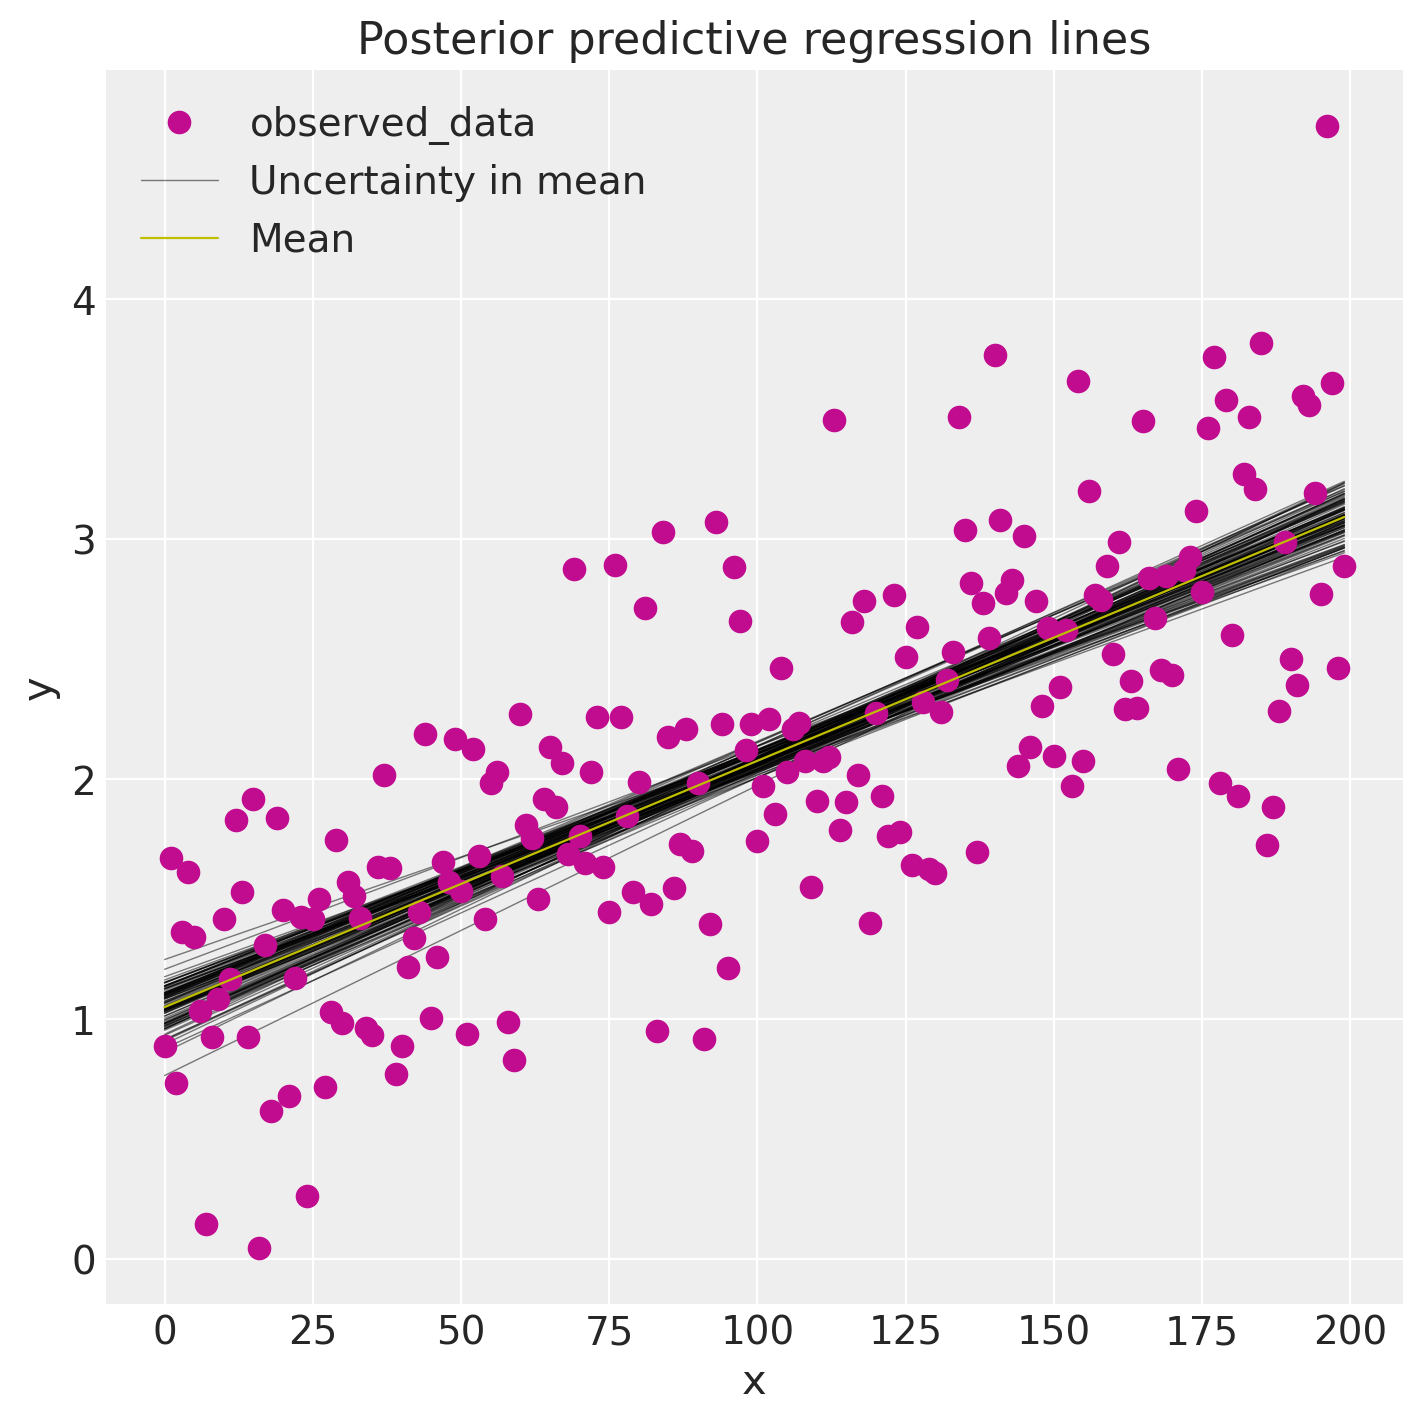

In [57]:
_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, y_model="y_model")
ax.set_title("Posterior predictive regression lines")
ax.set_xlabel("x");